# Python Lab Activity 2.4: Model Selection/Comparison using Cross-Validation

## Objectives:
1. Prepare the dataset for training by handling categorical variables and normalizing numerical features.
2. Use cross-validation to evaluate different hyperparameter settings for a Decision Tree model.
3. Visualize the impact of hyperparameters on model performance.

## Dataset

The dataset provided is `Obesity.csv1, the **Obesity Levels Dataset**, designed to study obesity classification based on a range of individual and lifestyle factors. It includes demographic information such as gender and age, physical measurements like height and weight, and behavioral factors such as eating habits, physical activity, and smoking status. Additionally, the dataset incorporates information on transportation modes and family history with overweight conditions. The dataset contains data for estimating obesity levels in individuals from Mexico, Peru, and Colombia, encompassing 17 attributes across 2130 records, see this [link](https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub) for the original study. Note that some protion of this dataset was synthetically generated while smaller portion of the data was collected directly from anonymous users through a web platform in 2019. 

The target variable, **`NObeyesdad`**, categorizes individuals into distinct weight levels, such as "Normal Weight," "Overweight," or various obesity levels. This dataset is well-suited for classification tasks, enabling researchers and data scientists to explore the relationships between lifestyle factors and obesity levels. By leveraging machine learning techniques, it provides an opportunity to build predictive models that can assess the impact of different factors on obesity and inform public health strategies.

## Step 1: Import Libraries and Load the Dataset


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Obesity.csv'
data = pd.read_csv(file_path)
data_og = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Step 2: Data Preprocessing

**Note**
The function `LabelEncoder()` transform the categorical variables into numbers, because clustering algorithms work on numerical data only.

**Overview**

1. Encode Categorical Features
- Use LabelEncoder to convert string categories (e.g. 'Male', 'Yes', 'Car') into integers.
- Appropriate for binary or ordinal features.
- ⚠️ For unordered nominal features, consider using One-Hot Encoding instead.

2. Encode Target Variable
- The target column 'NObeyesdad' (obesity class) is encoded numerically.
- This prepares the label for classification or evaluation.

3. Normalize Numerical Features
- Use StandardScaler to standardize numerical columns (e.g. Age, Weight, FCVC, etc.).
- Ensures all features have mean = 0 and standard deviation = 1.
- Crucial for distance-based models (e.g. K-Means, SVM).

4. Split into Features and Target
- X = all predictor features (input)
- y = encoded target labels (output)

In [6]:
# Encode categorical variables
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
label_encoders = {col: LabelEncoder() for col in categorical_features}

for col in categorical_features:
    data[col] = label_encoders[col].fit_transform(data[col])

# Target encoding
data['NObeyesdad'] = LabelEncoder().fit_transform(data['NObeyesdad'])

# Normalize numerical features
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Split data into features and target
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

## Step 3: Model Selection with Cross-Validation
5. Handle Missing Values
- In `X`: If any missing values exist, impute using the column-wise mean via SimpleImputer.
- In `y`: If any target values are missing, drop the corresponding rows entirely.
- Logic is robust to both Pandas and NumPy formats.

6. Decision Tree Classifier
- Instantiate a `DecisionTreeClassifier` with a fixed random_state for reproducibility.

7. Grid Search with Cross-Validation
- Tune the following hyperparameters:
- criterion: 'gini', 'entropy'
- max_depth: None, 5, 10, 20
- min_samples_split: 2, 5, 10
- min_samples_leaf: 1, 2, 4

Use 5-fold cross-validation and accuracy as the scoring metric.

`GridSearchCV` returns:
- best_params_: optimal parameter combination
- best_score_: corresponding cross-validation accuracy


In [9]:
# Check for missing values in X
if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
    if X.isnull().values.any():
        print("Missing values detected in X. Imputing missing values...")
        # Impute missing values in X with the mean of each column
        imputer = SimpleImputer(strategy="mean")
        X = imputer.fit_transform(X)
else:
    if np.isnan(X).any():
        print("Missing values detected in X. Imputing missing values...")
        # Impute missing values in X with the mean of each column
        imputer = SimpleImputer(strategy="mean")
        X = imputer.fit_transform(X)

# Check for missing values in y
if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
    if y.isnull().values.any():
        print("Missing values detected in y. Dropping rows with missing target values...")
        # Drop rows with missing target values
        data = pd.concat([pd.DataFrame(X), pd.Series(y, name='target')], axis=1)
        data = data.dropna()
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values
else:
    if np.isnan(y).any():
        print("Missing values detected in y. Dropping rows with missing target values...")
        # Drop rows with missing target values
        data = np.column_stack((X, y))
        data = data[~np.isnan(data).any(axis=1)]
        X, y = data[:, :-1], data[:, -1]

# Define the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],      # Splitting criteria
    'max_depth': [None, 5, 10, 20],        # Depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]          # Minimum samples required in a leaf node
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and corresponding accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)


c:\Users\dylan\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Accuracy: 0.9263702433178305


The outcome of this code provides insights into the optimal configuration of the Decision Tree model for the given dataset, based on hyperparameter tuning performed using Grid Search with Cross-Validation. Here's how to interpret the results:

 - The best Decision Tree model uses the `gini` criterion for splits, a maximum depth of 10, requires at least 5 samples to split a node, and ensures at least 2 samples per leaf.
  - The model achieves an average accuracy of **93%** during cross-validation, indicating it is likely to perform well on new, unseen data.

## Step 4: Evaluate the Best Model

In [12]:
target_encoder = LabelEncoder()
target_encoder.fit_transform(data['NObeyesdad'])

array([1, 1, 1, ..., 3, 4, 7], dtype=int64)

Test Accuracy: 0.9437939110070258

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        55
           1       0.86      0.93      0.89        58
           2       0.92      0.99      0.95        70
           3       0.98      0.97      0.97        60
           4       1.00      0.98      0.99        66
           5       0.90      0.91      0.91        58
           6       0.96      0.90      0.93        58
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         1

    accuracy                           0.94       427
   macro avg       0.85      0.85      0.85       427
weighted avg       0.94      0.94      0.94       427



c:\Users\dylan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dylan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dylan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


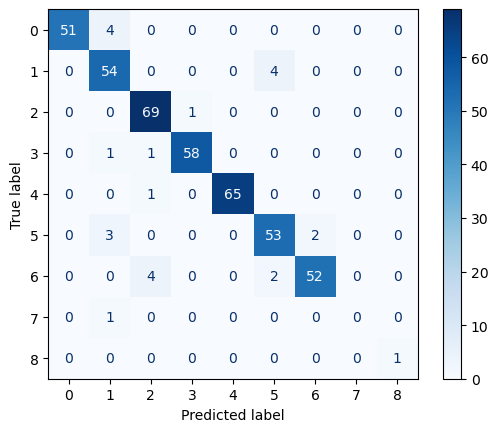

In [ ]:
# Encode the target variable and store the encoder
target_encoder = LabelEncoder()
data['NObeyesdad'] = target_encoder.fit_transform(data['NObeyesdad'])

# Split data into training and testing sets (stratified to handle imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Test set predictions
y_pred = best_model.predict(X_test)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, display_labels=target_encoder.classes_, cmap='Blues'
)
plt.show()



# Interpretation and some hints 
* **Test Accuracy** shows the overall proportion of correctly predicted samples out of all test samples. A high accuracy value indicates that the model correctly classifies most of the test set. If the dataset is **imbalanced**, accuracy might not reflect the model's true performance, as it may achieve high accuracy by favoring the majority class while ignoring minority classes. For balanced datasets, accuracy is a reliable indicator of model performance, but for imbalanced datasets, use additional metrics (precision, recall, F1-score) for a more comprehensive evaluation.

* **Classification Report** represents a detailed breakdown of performance metrics for each class:
    - **Precision**: Proportion of correctly predicted samples for a class out of all predicted samples for that class.
    - **Recall**: Proportion of correctly predicted samples for a class out of all actual samples for that class.
    - **F1-Score**: The harmonic mean of precision and recall.
    - **Support**: The number of actual samples for each class in the test set.

- **Keep in mind that**:
  - Classes with high precision and recall are well-handled by the model.
  - Low precision for certain classes means the model is misclassifying other classes as this class.
  - Low recall for certain classes means the model is failing to identify samples belonging to this class.
  - Discrepancies in F1-score across classes highlight areas where the model struggles (e.g., with minority or overlapping classes).

* **Confusion Matrix** shows where the model makes errors. It is a heatmap where:
    - **Diagonal elements**: Correct predictions for each class (true positives).
    - **Off-diagonal elements**: Misclassifications, indicating where the model confused one class for another.

- **Keep in mind that**:
  - Large diagonal values indicate that the model performs well for those classes.
  - Significant off-diagonal values highlight areas of confusion, such as:
    - Misclassifying similar classes (e.g., "Obesity Type I" as "Obesity Type II").
    - Failing to predict minority classes entirely.

### Takeaways
1. **Balanced Classes.** If all metrics (accuracy, precision, recall, F1-score) are high and consistent across classes, the model performs well.

2. **Imbalanced Classes.** Low precision, recall, or F1-score for minority classes indicates the need for techniques like class weighting or oversampling.

3. **Confusion Patterns.** Misclassifications shown in the confusion matrix can provide insights into feature overlap or class similarities, guiding further model improvement.

### Verifying Class Distribution:
To ensure proper stratification and class representation:

In [13]:
# Check class distribution in the dataset and splits
print("Original class distribution:")
print(data['NObeyesdad'].value_counts())
print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())
print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())

Original class distribution:
NObeyesdad
2    352
4    329
3    300
5    290
6    290
1    289
0    274
8      4
7      3
Name: count, dtype: int64

Training set class distribution:
NObeyesdad
2    282
4    263
3    240
6    232
5    232
1    231
0    219
8      3
7      2
Name: count, dtype: int64

Test set class distribution:
NObeyesdad
2    70
4    66
3    60
6    58
5    58
1    58
0    55
8     1
7     1
Name: count, dtype: int64


## Step 5: Visualize Cross-Validation Results

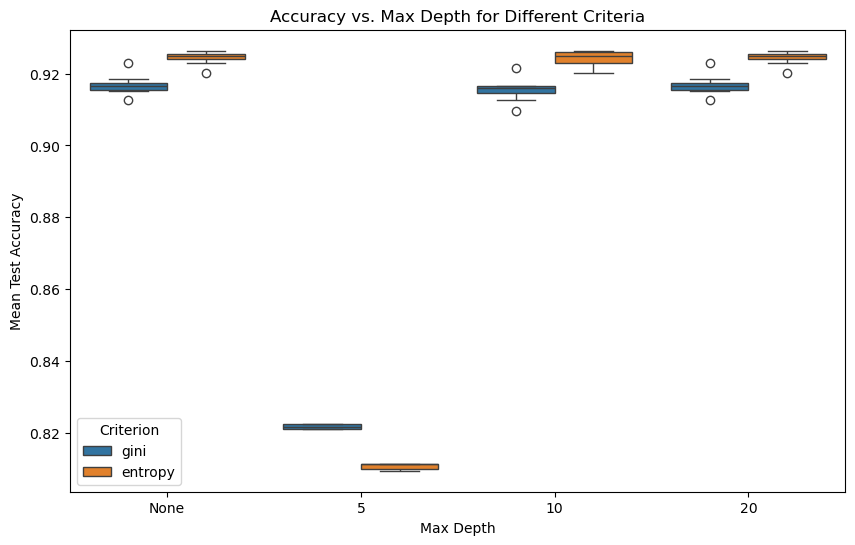

In [14]:
# Extract cross-validation results
results = pd.DataFrame(grid_search.cv_results_)

# Replace None values in 'param_max_depth' with a string for plotting
results['param_max_depth'] = results['param_max_depth'].astype(str)

# Plot accuracy vs. hyperparameters
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x='param_max_depth', y='mean_test_score', hue='param_criterion')
plt.title("Accuracy vs. Max Depth for Different Criteria")
plt.xlabel("Max Depth")
plt.ylabel("Mean Test Accuracy")
plt.legend(title="Criterion")
plt.show()

### Expected Output:
1. **Best Parameters**: Hyperparameters that give the highest cross-validation accuracy.
2. **Confusion Matrix**: Visualization of model predictions on the test set.
3. **Accuracy Graph**: Boxplot showing how accuracy varies with `max_depth` and `criterion`.

# A sample decision tree visualization
The following Python code visualize a decision tree with the best parameters obtained from the model selection above:

### **Expected Output**
- A plot of the decision tree, where:
  - Nodes represent decisions based on feature splits.
  - Leaf nodes represent the predicted classes.
  - Colors indicate the predicted class (or impurity if multiple classes exist in a leaf).


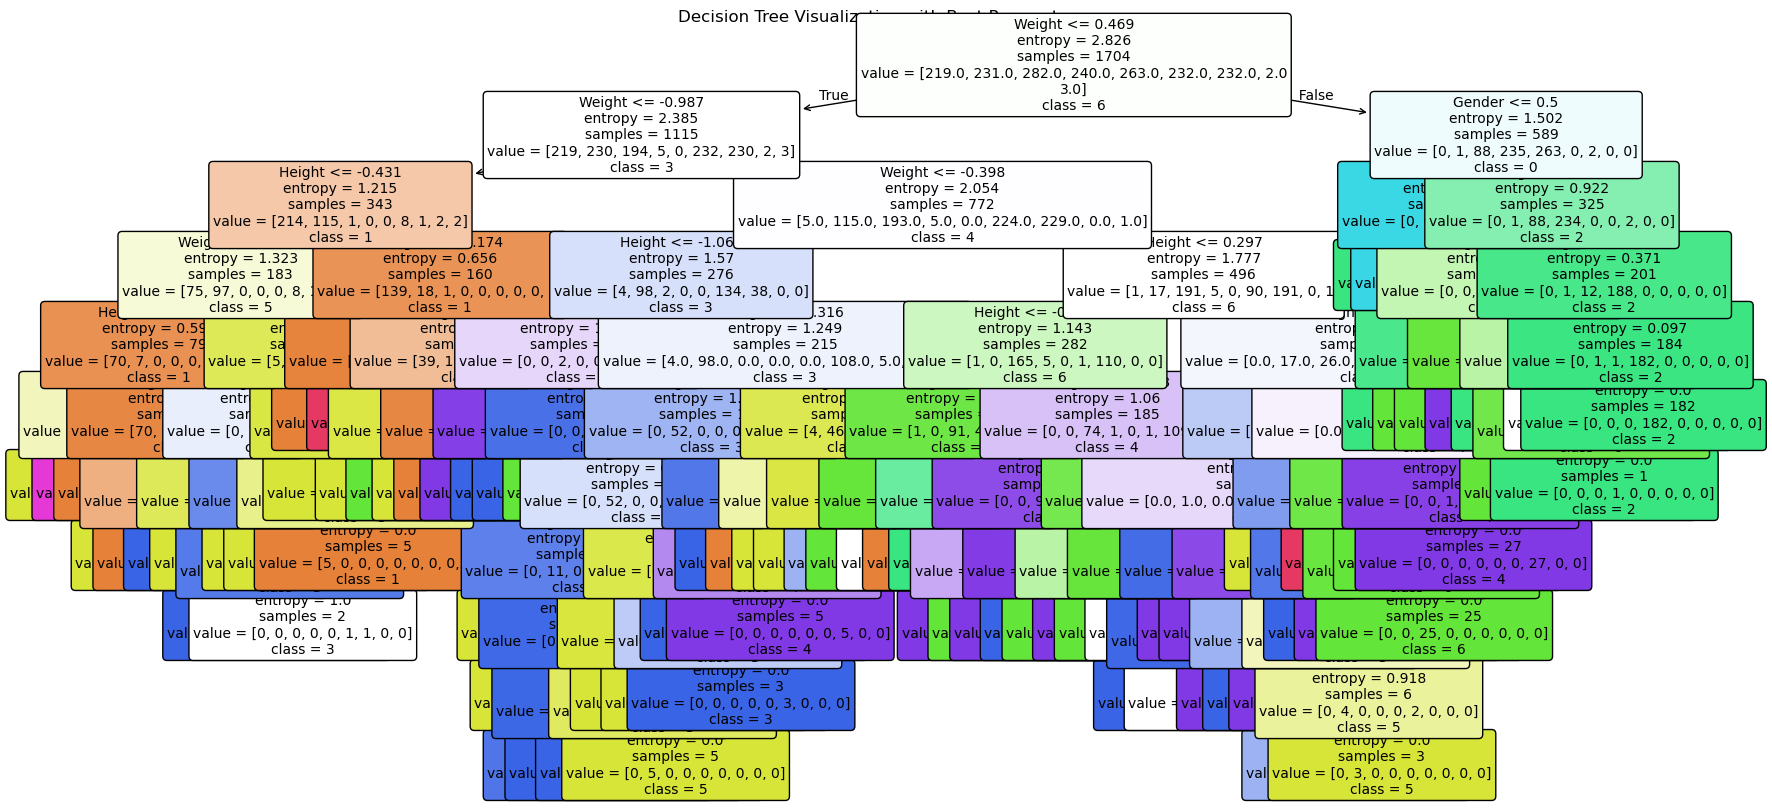

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract feature names from the dataset (exclude the target column)
feature_names = data.drop(columns=["NObeyesdad"]).columns.tolist()

# Get the best decision tree model from the grid search
best_model = grid_search.best_estimator_

# Convert class names to strings (from the target column)
class_names = data["NObeyesdad"].unique().astype(str).tolist()

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_model, 
    feature_names=feature_names,  # Use the feature names extracted from the dataset
    class_names=class_names,      # Use the unique class names from the target column
    filled=True, 
    rounded=True, 
    fontsize=10
)
plt.title("Decision Tree Visualization with Best Parameters")
plt.show()

Recall that to reduce the density of the decision tree, we can set an appropriate value for the `max_depth` parameter. This will limit the depth of the tree, making it easier to interpret and less likely to overfit the data. Here’s the modified code with an added step to set the `max_depth` to the optimal value identified during the grid search:

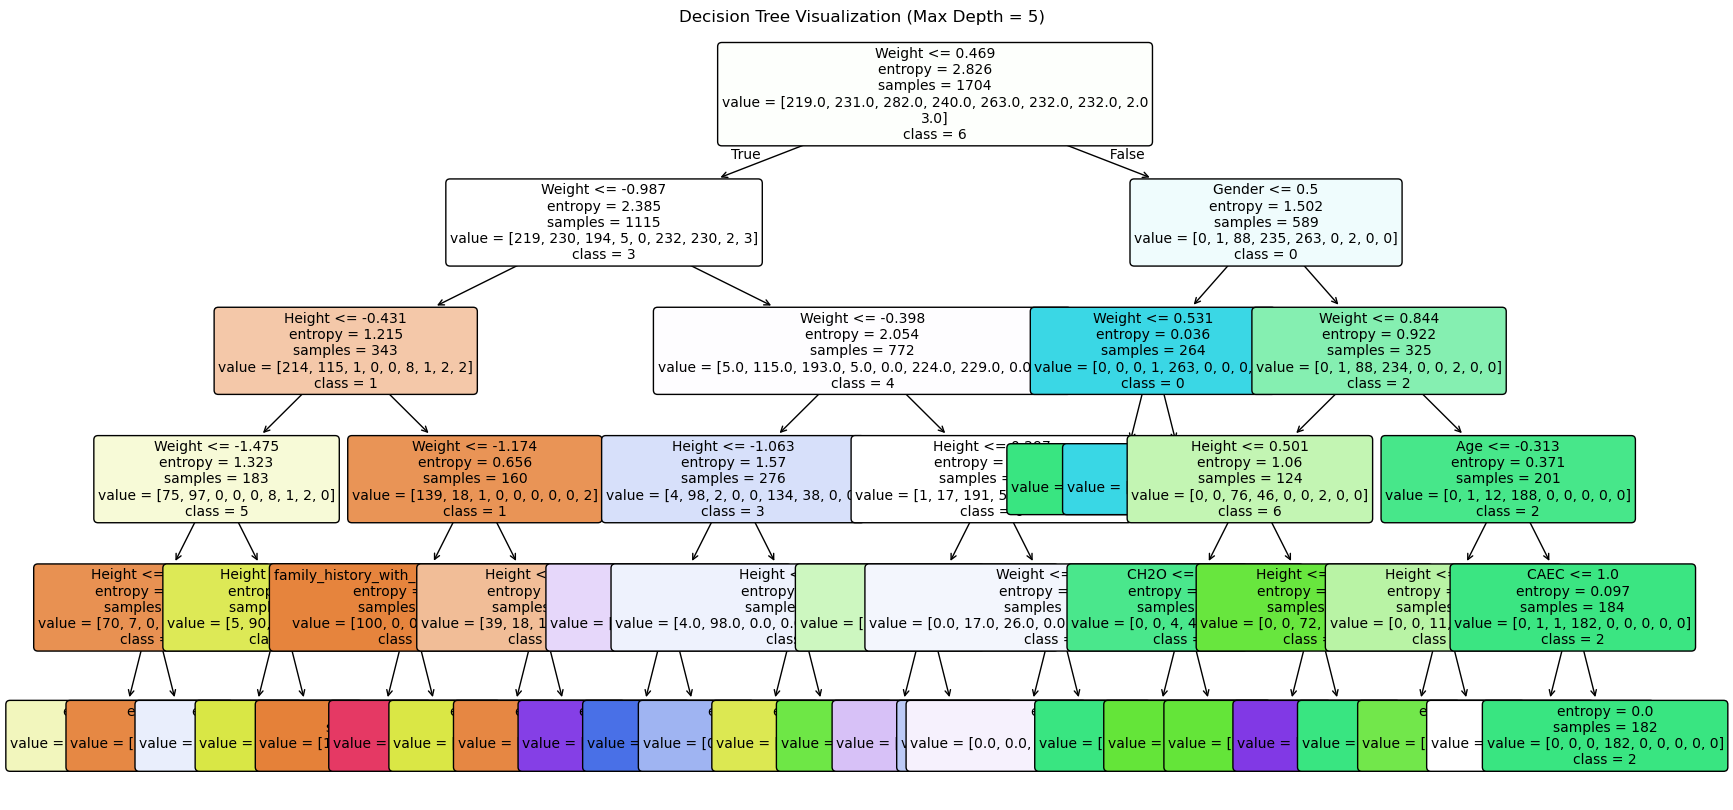

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Extract feature names from the dataset (exclude the target column)
feature_names = data.drop(columns=["NObeyesdad"]).columns.tolist()

# Extract class names from the target column
class_names = data["NObeyesdad"].unique().astype(str).tolist()

# Get the best decision tree model from the grid search
best_model = grid_search.best_estimator_

# Set an appropriate max_depth for a less dense tree
optimal_max_depth = best_model.get_params()['max_depth']
if optimal_max_depth is None or optimal_max_depth > 5:
    optimal_max_depth = 5  # Limit max_depth to 5 if the grid search suggests a very large value

# Create a new decision tree with reduced depth
reduced_model = DecisionTreeClassifier(
    criterion=best_model.get_params()['criterion'],  # Use the same criterion
    max_depth=optimal_max_depth,  # Use the reduced depth
    random_state=42
)

# Retrain the model with the reduced depth
reduced_model.fit(X_train, y_train)  # Ensure X_train and y_train are preprocessed properly

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    reduced_model,
    feature_names=feature_names,  # Use the feature names extracted from the dataset
    class_names=class_names,      # Use the unique class names from the target column
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Decision Tree Visualization (Max Depth = {optimal_max_depth})")
plt.show()


### **Task 1: Analyze Class Distribution and Its Impact on Model Performance**
#### Problem:
1. Check the distribution of the target variable (`NObeyesdad`) in the dataset.
2. Explain how class imbalance can affect model performance, particularly for precision, recall, and F1-score.
3. Propose and implement a solution to handle the imbalance, if necessary.

# Sample Solution for the Task 1

Class Distribution:
 2    352
4    329
3    300
5    290
6    290
1    289
0    274
8      4
7      3
Name: NObeyesdad, dtype: int64


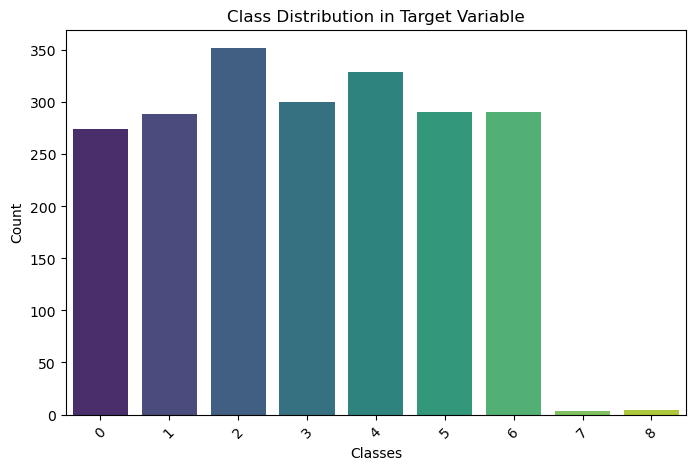

Initial Classification Report (without handling imbalance):

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        55
           1       0.86      0.93      0.89        58
           2       0.92      0.99      0.95        70
           3       0.98      0.97      0.97        60
           4       1.00      0.98      0.99        66
           5       0.90      0.91      0.91        58
           6       0.96      0.90      0.93        58
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         1

    accuracy                           0.94       427
   macro avg       0.85      0.85      0.85       427
weighted avg       0.94      0.94      0.94       427

Classification Report with Balanced Class Weights:

              precision    recall  f1-score   support

           0       0.98      0.87      0.92        55
           1       0.77      0.86      0.81        58
           2       

In [9]:
# Analyze class distribution
class_counts = data['NObeyesdad'].value_counts()
print("Class Distribution:\n", class_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution in Target Variable")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Convert target classes to strings for the classification report
target_names = [str(cls) for cls in target_encoder.inverse_transform(range(len(target_encoder.classes_)))]

# Evaluate the impact of class imbalance
print("Initial Classification Report (without handling imbalance):\n")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# Implement a solution: Use class weights in Decision Tree
dt_model_weighted = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model with balanced class weights
dt_model_weighted.fit(X_train, y_train)
y_pred_weighted = dt_model_weighted.predict(X_test)

# Re-evaluate performance after handling class imbalance
print("Classification Report with Balanced Class Weights:\n")
print(classification_report(y_test, y_pred_weighted, target_names=target_names, zero_division=0))

#### Expected Outcome:
1. **Initial Analysis**:
   - The class distribution bar plot reveals imbalanced classes (e.g., some obesity categories may have far fewer samples than others).
   - The initial classification report might show poor precision, recall, or F1-score for underrepresented classes.

2. **After Handling Imbalance**:
   - The use of `class_weight='balanced'` adjusts the model’s emphasis during training, improving the performance (e.g., precision/recall) of underrepresented classes.

### **Task 2: Compare Model Performance with Different Hyperparameters**
#### Problem:
1. Compare the performance of the Decision Tree model using **different splitting criteria** (`gini` vs. `entropy`) and **maximum depth** values.
2. Visualize the performance trends to identify the best hyperparameter combination.


In [10]:
#### Sample solution to task 2

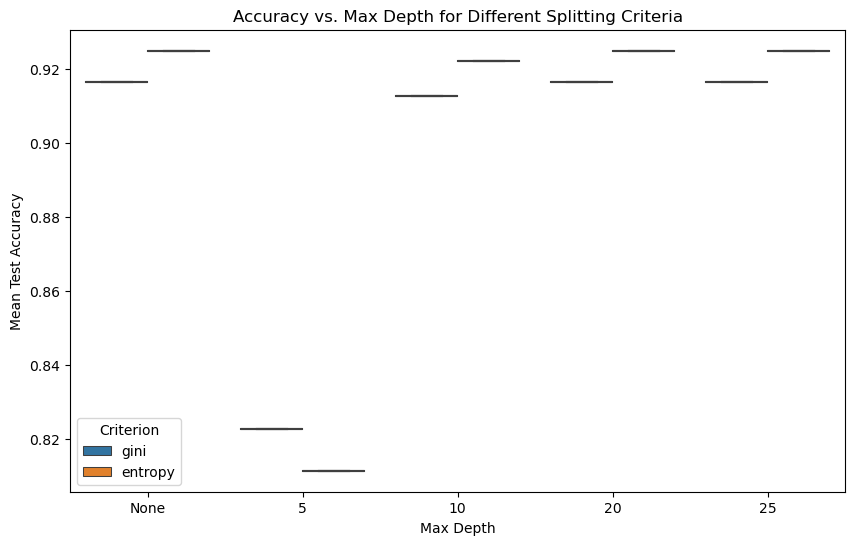

Best Parameters: {'criterion': 'entropy', 'max_depth': None}
Best Cross-Validation Accuracy: 0.9249617926136052


In [11]:
# 1. Define hyperparameters to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 25]
}

# 2. Perform Grid Search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X, y)

# 3. Extract cross-validation results
results = pd.DataFrame(grid_search.cv_results_)

# Replace None in max_depth for easier visualization
results['param_max_depth'] = results['param_max_depth'].astype(str)

# 4. Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x='param_max_depth', y='mean_test_score', hue='param_criterion')
plt.title("Accuracy vs. Max Depth for Different Splitting Criteria")
plt.xlabel("Max Depth")
plt.ylabel("Mean Test Accuracy")
plt.legend(title="Criterion")
plt.show()

# 5. Output the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

#### Expected Outcome:
1. **Performance Trends**:
   - The box plot shows how accuracy varies with different `max_depth` values for each splitting criterion (`gini` vs. `entropy`).
   - Shallower trees (e.g., `max_depth=5`) may result in lower accuracy due to underfitting, while very deep trees (e.g., `max_depth=20`) might show signs of overfitting.

2. **Best Hyperparameters**:
   - The best combination of hyperparameters is displayed based on cross-validation accuracy.

3. **Takeaways**:
   - Insights from the plot and grid search can guide optimal model tuning for this dataset.